In [1]:
import pandas as pd
import numpy as np
import pm4py
from matplotlib import pyplot as plt
import seaborn as sns
from fitter import Fitter
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

### Importazione dataset

In [3]:
df_traces = pd.read_csv('C:/Users/HP/Desktop/df_traces_from_weigh.csv')
df_traces.drop('Unnamed: 0', axis=1, inplace=True)

df_t_est = pd.read_csv('C:/Users/HP/Desktop/df_t_est.csv')
df_t_est.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
len(df_traces['ID_unique'].unique())

1858

event_log = df_traces[['ID', 'stato', 'ubicazione', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['ID', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)
event_log = pm4py.format_dataframe(event_log, case_id='ID_unique', activity_key='rif', timestamp_key='timestamp')

In [4]:
event_log = df_traces[['cono', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['cono', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)
event_log = pm4py.format_dataframe(event_log, case_id='ID_unique', activity_key='rif', timestamp_key='timestamp')

In [6]:
len(event_log['ID_unique'].unique())

1858

### Calcolo tempi di interarrivo

In [7]:
df_int = event_log[event_log['rif'] == 'V_da_pes/pesatura']

In [8]:
#df_int.drop_duplicates(subset='ID_unique', inplace=True)

In [9]:
df_int.sort_values('timestamp', inplace=True)
df_int.reset_index(drop=True, inplace=True)

In [10]:
intervals = []

for i in range(len(df_int) - 1):
    time_delta = df_int.loc[i + 1, 'timestamp'] - df_int.loc[i, 'timestamp']
    dt = time_delta.total_seconds() / 60
    intervals.append(dt)

In [11]:
len(intervals)

2701

In [12]:
intervals = quantile2(intervals,0.95,0)

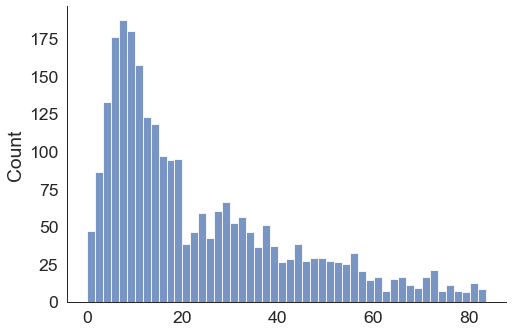

In [13]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=intervals, kind="hist", bins = 50, aspect = 1.5)

,sumsquare_error,aic,bic,kl_div
exponnorm,0.003912,1001.434962,-34330.711574,0.095773
wald,0.003961,1004.663712,-34306.567379,0.096776
laplace_asymmetric,0.004046,1002.415394,-34244.178711,0.097518
fatiguelife,0.004056,1004.464061,-34238.041044,0.099082
invgauss,0.004109,1008.844156,-34204.607328,0.101694


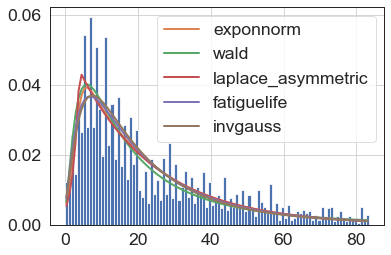

In [14]:
#  extract best fitting distribution
f = Fitter(intervals)
f.fit()
f.summary()

In [15]:
f.get_best(method = 'sumsquare_error')

{'exponnorm': {'K': 11.104910675950897,
  'loc': 2.4978029318681854,
  'scale': 1.8719192372024525}}

### Pre processing

In [5]:
#  remove traces with 'recheck' as activity
'''mask_recheck = np.asarray( event_log[ event_log['stato'] == 'P_recheck' ].index )
ID_recheck = event_log.loc[mask_recheck]['ID_unique'].values
mask_drop_recheck = np.asarray( event_log[ event_log['ID_unique'].isin(ID_recheck)].index )
event_log.drop( mask_drop_recheck, inplace = True )'''

#  visualize start/end activities
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'V_da_pes/pesatura': 1858}
End activities: {'V_per_park/estrusore': 1725, 'V_da_pes/estrusore': 107, 'V_remove/estrusore': 9, 'P_da_est/fuori_impianto': 6, 'P_da_est/estrusore': 3, 'V_per_park/catenaria_parcheggi': 2, 'V_da_pes/pesatura': 2, 'Not_def/fuori_impianto': 2, 'P_da_est/buffer': 1, 'P_da_est/carroponte_2': 1}


In [6]:
#  filtering event log by start activiy
from pm4py.algo.filtering.pandas.start_activities import start_activities_filter
event_log = start_activities_filter.apply(event_log, ['V_da_pes/pesatura'],
                                          parameters={start_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      start_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_start_activities(event_log)

{'V_da_pes/pesatura': 1858}

In [7]:
#  filtering event log by end activiy
from pm4py.algo.filtering.pandas.end_activities import end_activities_filter
event_log = end_activities_filter.apply(event_log, ['V_per_park/estrusore', 'V_da_pes/estrusore'],
                                          parameters={end_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      end_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_end_activities(event_log)

{'V_per_park/estrusore': 1725, 'V_da_pes/estrusore': 107}

In [8]:
#  fitering event log removing reworked traces
df_rework = pm4py.filter_activities_rework(event_log, "V_da_pes/catenaria_ing_misc", 2)
event_log.drop( df_rework.index, inplace = True )

### Process mining

In [9]:
#  evaluate number of variants
from pm4py.statistics.traces.generic.pandas import case_statistics
variants_count = case_statistics.get_variant_statistics(event_log,
                                          parameters={case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      case_statistics.Parameters.ACTIVITY_KEY: "concept:name",
                                                      case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})
variants_count = sorted(variants_count, key=lambda x: x['case:concept:name'], reverse=True)
len(variants_count)

346

In [21]:
variants_count

[{'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 326},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/buffer,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 296},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/cat_usc_pieni,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 277},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/cat_usc_pieni,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/buffer,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 225},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_mi

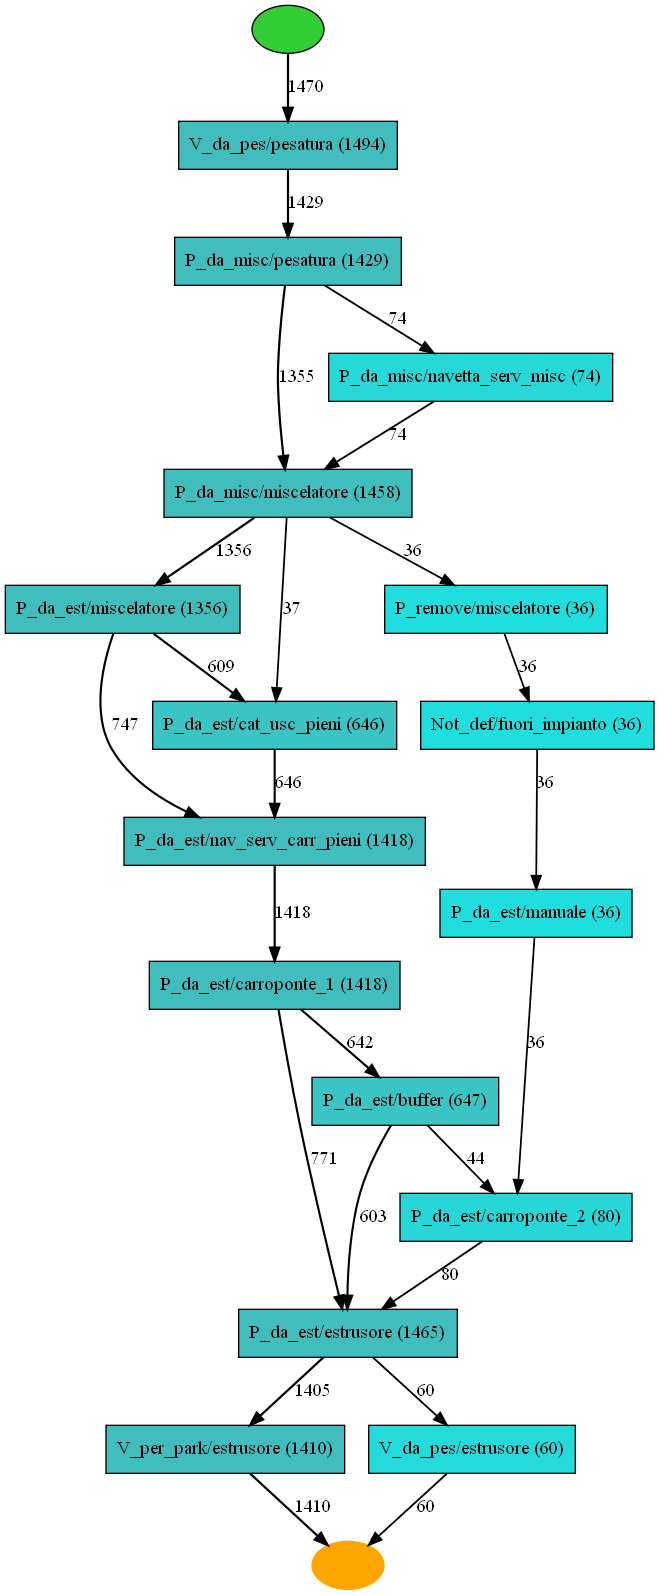

In [10]:
#  take most significant variants
filtered_log = pm4py.filter_variants_top_k(event_log, 30)

#  visualize heuristic net
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
heu_net = heuristics_miner.apply_heu(filtered_log,
                                     parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 1,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.LOOP_LENGTH_TWO_THRESH: 2})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [23]:
pm4py.save_vis_heuristics_net(heu_net, 'C:/Users/HP/Desktop/huristicnet_post_pes.png')

In [24]:
filtered_log

,cono,rif,ID_unique,timestamp,case:concept:name,concept:name,time:timestamp,@@index
0,1,V_da_pes/pesatura,0C1,2022-03-23 01:54:52+00:00,0C1,V_da_pes/pesatura,2022-03-23 01:54:52+00:00,0
1,1,P_da_misc/pesatura,0C1,2022-03-23 02:09:10+00:00,0C1,P_da_misc/pesatura,2022-03-23 02:09:10+00:00,1
2,1,P_da_misc/miscelatore,0C1,2022-03-23 02:11:28+00:00,0C1,P_da_misc/miscelatore,2022-03-23 02:11:28+00:00,2
3,1,P_da_est/miscelatore,0C1,2022-03-23 02:13:45+00:00,0C1,P_da_est/miscelatore,2022-03-23 02:13:45+00:00,3
4,1,P_da_est/cat_usc_pieni,0C1,2022-03-23 02:14:54+00:00,0C1,P_da_est/cat_usc_pieni,2022-03-23 02:14:54+00:00,4
...,...,...,...,...,...,...,...,...
5066,7,P_da_est/miscelatore,9C7,2022-03-30 14:22:54+00:00,9C7,P_da_est/miscelatore,2022-03-30 14:22:54+00:00,5066
5067,7,P_da_est/nav_serv_carr_pieni,9C7,2022-03-30 14:25:11+00:00,9C7,P_da_est/nav_serv_carr_pieni,2022-03-30 14:25:11+00:00,5067
5068,7,P_da_est/carroponte_1,9C7,2022-03-30 14:26:54+00:00,9C7,P_da_est/carroponte_1,2022-03-30 14:26:54+00:00,5068
5069,7,P_da_est/estrusore,9C7,2022-03-30 14:28:37+00:00,9C7,P_da_est/estrusore,2022-03-30 14:28:37+00:00,5069


### Calcolo intertempi tra le attività

In [13]:
delta_t_est = {'pesatura': [],
              'hand_to_misc': [],
              'miscelazione': [],
              'hand_to_est':[],
              'estrusione': []}

df_est = filtered_log[['ID_unique', 'rif', 'timestamp']].copy()

In [14]:
for idu in df_est['ID_unique'].unique():
    mask = df_est['ID_unique'] == idu
    df_tmp = df_est[mask].sort_values('timestamp')
    df_tmp.set_index('rif', inplace=True)
    if len(df_tmp) == len(df_tmp.index.unique()):
        for k in delta_t_est:
            minuendo = None
            sottraendo = None
            if k == 'pesatura':
                if 'P_da_misc/pesatura' in df_tmp.index:
                    minuendo = 'P_da_misc/pesatura'
                    sottraendo = 'V_da_pes/pesatura'
                else:
                    continue
                #-----------
            elif k == 'hand_to_misc':
                if 'P_da_misc/pesatura' in df_tmp.index:
                    minuendo = 'P_da_misc/miscelatore'
                    sottraendo = 'P_da_misc/pesatura'
                else:
                    continue
                #-----------
            elif k == 'miscelazione':
                if 'P_remove/miscelatore' in df_tmp.index:
                    minuendo = 'P_remove/miscelatore'
                    sottraendo = 'P_da_misc/miscelatore'
                elif 'P_da_est/miscelatore' in df_tmp.index:
                    minuendo = 'P_da_est/miscelatore'
                    sottraendo = 'P_da_misc/miscelatore'
                #----------------
            elif k == 'hand_to_est':
                if 'P_da_est/buffer' in df_tmp.index and 'P_da_est/cat_usc_pieni' in df_tmp.index:
                    minuendo = 'P_da_est/buffer'
                    sottraendo = 'P_da_est/cat_usc_pieni'
                elif 'P_da_est/buffer' in df_tmp.index and 'P_da_est/miscelatore' in df_tmp.index and 'P_da_est/cat_usc_pieni' not in df_tmp.index:
                    minuendo = 'P_da_est/buffer'
                    sottraendo = 'P_da_est/miscelatore'
                elif 'P_da_est/estrusore' in df_tmp.index and 'P_da_est/cat_usc_pieni' in df_tmp.index and 'P_da_est/buffer' not in df_tmp.index:
                    minuendo = 'P_da_est/estrusore'
                    sottraendo = 'P_da_est/cat_usc_pieni'
                elif 'P_da_est/estrusore' in df_tmp.index and 'P_da_est/miscelatore' in df_tmp.index and 'P_da_est/cat_usc_pieni' not in df_tmp.index and 'P_da_est/buffer' not in df_tmp.index:
                    minuendo = 'P_da_est/estrusore'
                    sottraendo = 'P_da_est/miscelatore'
                # ------------------
            elif k == 'estrusione':
                if 'V_da_pes/estrusore' in df_tmp.index:
                    minuendo = 'V_da_pes/estrusore'
                    sottraendo = 'P_da_est/estrusore'
                else:
                    minuendo = 'V_per_park/estrusore'
                    sottraendo = 'P_da_est/estrusore'

            if minuendo in df_tmp.index and sottraendo in df_tmp.index:
                dt = np.round(
                    (df_tmp.loc[minuendo, 'timestamp'] - df_tmp.loc[sottraendo, 'timestamp']).total_seconds() / 60, 4)
                delta_t_est[k].append(dt)

In [27]:
delta_t_est.keys()

dict_keys(['pesatura', 'hand_to_misc', 'miscelazione', 'hand_to_est', 'estrusione'])

In [15]:
def quantile(column,pct,pct_lower):
    y = column
    y.dropna(inplace=True)
    y = y.values
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return (y)

In [16]:
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

In [30]:
for k in delta_t_est:
    delta_t_est[k] = quantile2( delta_t_est[k], 0.999, 0.001)
# non l'ho fatta per ora

In [17]:
df_dt = pd.DataFrame.from_dict(delta_t_est, orient='index').transpose()

In [18]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pesatura      1401 non-null   float64
 1   hand_to_misc  1401 non-null   float64
 2   miscelazione  1364 non-null   float64
 3   hand_to_est   1360 non-null   float64
 4   estrusione    1437 non-null   float64
dtypes: float64(5)
memory usage: 56.3 KB


### Data visualization

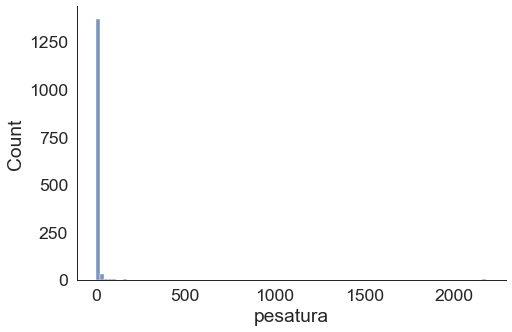

In [32]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="pesatura", kind="hist", bins = 100, aspect = 1.5)

In [33]:
np.mean(quantile(df_dt['pesatura'], 0.99, 0))

9.030218181818181

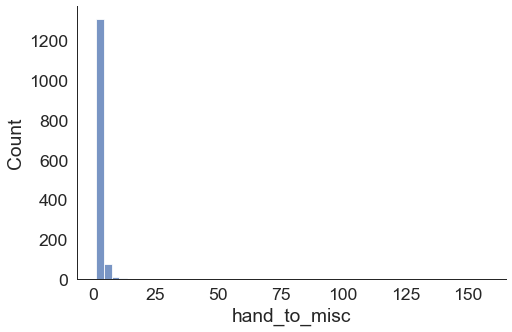

In [34]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="hand_to_misc", kind="hist", bins = 50, aspect = 1.5)

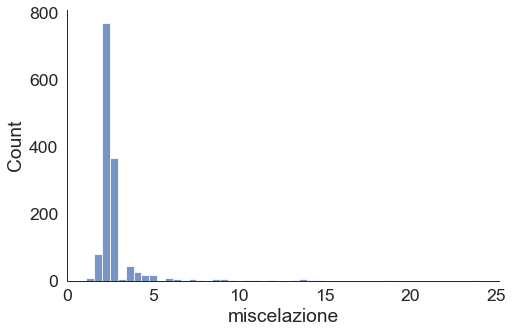

In [35]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="miscelazione", kind="hist", bins = 50, aspect = 1.5)

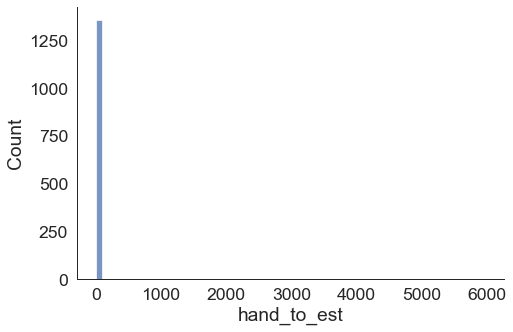

In [36]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="hand_to_est", kind="hist", bins = 60, aspect = 1.5)

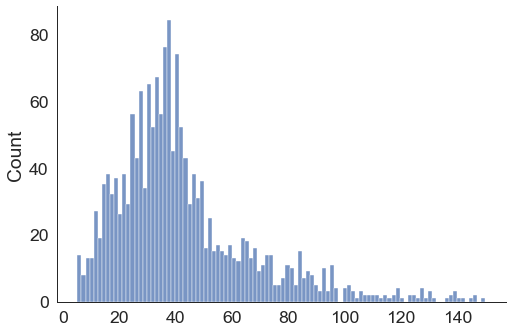

In [37]:
ns = pd.concat([df_dt['estrusione'], df_t_est['est_time']], ignore_index=True)
dt_est = quantile(ns, 0.99, 0.01)
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=dt_est, kind="hist", bins = 100, aspect = 1.5)

### Fitting distributions to data

,sumsquare_error,aic,bic,kl_div
invgamma,4.861794e-07,5197.493741,-30494.328493,inf
laplace,2.129533e-06,38343.307192,-28432.183523,inf
exponnorm,1.413184e-05,27932.970937,-25773.507930,inf
halflogistic,1.615648e-05,32120.755951,-25593.171105,inf
laplace_asymmetric,1.870295e-05,27608.924537,-25380.876406,inf


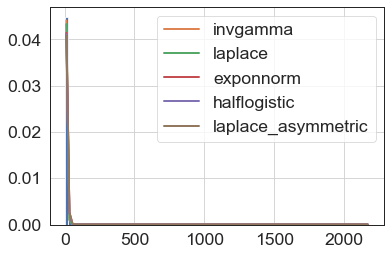

In [38]:
#  extract best fitting distribution from 'pesatura'
#data = quantile(df_dt['pesatura'], 0.99, 0.01)
data = df_dt['pesatura']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [39]:
f.get_best(method = 'sumsquare_error')

{'invgamma': {'a': 5.591250717049744,
  'loc': -2.5856828905603355,
  'scale': 55.61417364542359}}

,sumsquare_error,aic,bic,kl_div
wald,0.001507,5352.886861,-19238.878880,inf
chi2,0.003474,13666.082610,-18061.331871,inf
gumbel_r,0.003831,19780.026141,-17931.888554,inf
expon,0.007613,9956.400252,-16969.649282,inf
laplace,0.008465,17804.908795,-16821.004107,inf


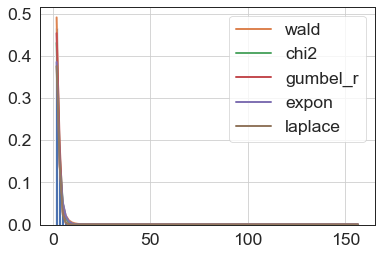

In [40]:
#  extract best fitting distribution from 'handling to misc'
#data = quantile(df_dt['pesatura'], 0.99, 0.01)
data = df_dt['hand_to_misc']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [41]:
f.get_best(method = 'sumsquare_error')

{'wald': {'loc': 1.0345698920401443, 'scale': 1.8598985366926324}}

,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,3.664126,3246.253648,-8052.662070,inf
laplace,4.640707,3887.915039,-7737.598767,inf
hypsecant,4.754381,4234.143611,-7704.590028,inf
gumbel_r,4.864506,3646.217120,-7673.356383,inf
logistic,4.971897,4691.938963,-7643.571603,inf


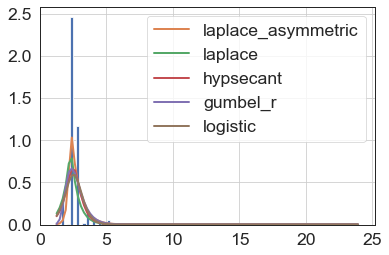

In [42]:
#  extract best fitting distribution from 'miscelazione'
# data = quantile(df_dt['miscelazione'], 0.99, 0.01)
data = df_dt['miscelazione']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [43]:
f.get_best(method = 'sumsquare_error')

{'laplace_asymmetric': {'kappa': 0.5297883518022284,
  'loc': 2.283299987520212,
  'scale': 0.3368510929754309}}

,sumsquare_error,aic,bic,kl_div
rayleigh,0.000187,4.827837e+04,-21475.447585,inf
expon,0.000199,7.824713e+04,-21390.080734,inf
norm,0.000214,4.642914e+04,-21287.001834,inf
gumbel_r,0.000249,1.166451e+05,-21086.157427,inf
laplace,0.000253,inf,-21060.447209,inf


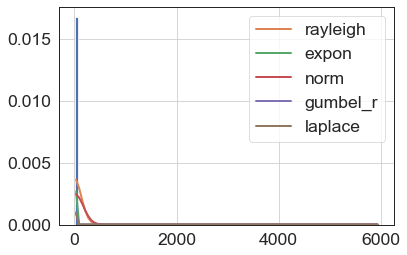

In [44]:
#  extract best fitting distribution from 'handling to estrusore'
#  data = quantile(df_dt['hand_to_est'], 0.99, 0.01)
data = df_dt['hand_to_est']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [45]:
f.get_best(method = 'sumsquare_error')

{'rayleigh': {'loc': -154.22122775090668, 'scale': 163.72329503305056}}

,sumsquare_error,aic,bic,kl_div
laplace,0.000822,1262.465982,-24862.247508,inf
gumbel_r,0.001009,1212.666375,-24511.479619,inf
logistic,0.001488,1295.819431,-23847.983495,inf
rayleigh,0.001516,1254.716884,-23815.460451,inf
norm,0.002245,1323.672091,-23144.436823,inf


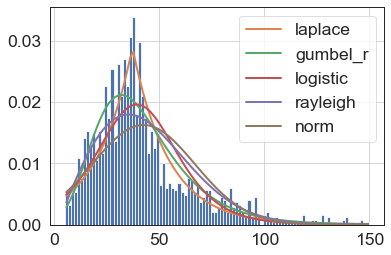

In [46]:
#  extract best fitting distribution from 'estrusione'
f = Fitter(dt_est)
f.fit()
f.summary()

In [47]:
f.get_best(method = 'sumsquare_error')

{'laplace': {'loc': 37.1667, 'scale': 17.241393918128658}}

### Tempo totale di attraversamento

In [11]:
def filtering(event_log, ubicazione):
    mask = event_log['rif'] == ubicazione
    get_ID = event_log[mask]['ID_unique'].unique()
    mask_id = event_log['ID_unique'].isin(get_ID)
    new_log = event_log[mask_id]
    return(new_log)

In [116]:
df_est = filtering(df_est, 'P_da_est/estrusore')

tc_list = []
for idu in df_est['ID_unique'].unique():
    mask = df_est['ID_unique'] == idu
    df_tmp = df_est[mask].sort_values('timestamp')
    df_tmp.reset_index(drop=True, inplace=True)
    t1 = df_tmp.loc[0, 'timestamp']
    t2 = df_tmp.loc[len(df_tmp) - 1, 'timestamp']
    tc = ((t2 - t1).seconds)/60
    tc_list.append(tc)

In [117]:
df_tc_sim = pd.read_csv('C:/Users/HP/Desktop/df_tc_sim.csv')

In [118]:
tc_sim = list(df_tc_sim['t_tot'])

In [119]:
len(tc_sim)

1801

In [120]:
len(tc_list)

1465

In [121]:
tc_list = quantile2(tc_list, 0.98, 0)
len(tc_list)

1435

In [122]:
tc_sim = quantile2(tc_sim, 0.98, 0)

In [123]:
from random import shuffle
shuffle(tc_sim)

In [124]:
tc_sim = tc_sim[(len(tc_sim) - (len(tc_list))):]
len(tc_sim)

1435

In [75]:
tc_list = [x + 1 for x in tc_list]

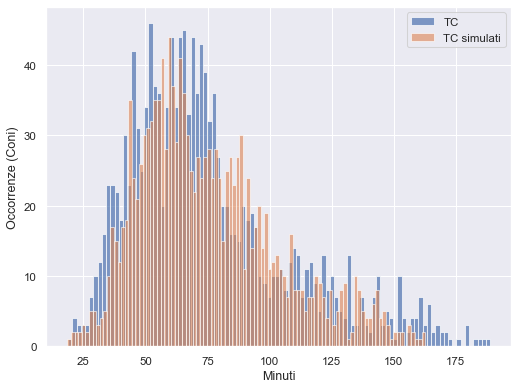

In [128]:
plt.figure(figsize=(8, 6), dpi=75)
plt.hist(tc_list, 100, alpha=0.7, label='TC')
plt.hist(tc_sim, 100, alpha=0.6, label='TC simulati')
plt.xlabel('Minuti')
plt.ylabel('Occorrenze (Coni)')
plt.legend(loc='upper right')
plt.savefig('C:/Users/HP/Desktop/dist_real_sim.png')
plt.show()

In [126]:
from sklearn.metrics import mean_squared_error
  
# Calculation of Root Mean Squared Error (RMSE)
np.sqrt(mean_squared_error(sorted(tc_list),sorted(tc_sim)))

5.285249650851645

In [127]:
mean_real = np.round(np.mean(tc_list), 2)
mean_sim = np.round(np.mean(tc_sim), 2)
print('Media delle osservazioni reali: {}\nMedia delle osservazioni simulate: {}'.format(mean_real, mean_sim))
print('')
mean_real = np.round(np.median(tc_list), 2)
mean_sim = np.round(np.median(tc_sim), 2)
print('Mediana delle osservazioni reali: {}\nMediana delle osservazioni simulate: {}'.format(mean_real, mean_sim))

Media delle osservazioni reali: 75.78
Media delle osservazioni simulate: 75.42

Mediana delle osservazioni reali: 68.67
Mediana delle osservazioni simulate: 70.15


In [132]:
np.round(np.std(tc_sim), 2)

28.04

In [130]:
np.round(np.median(tc_list), 2)

68.67

In [133]:
from random import random

In [137]:
random()

0.837099444981394